### Imports

In [88]:
import warnings
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
import Bio.PDB as bp
from ruamel.yaml import YAML
import seaborn as sb
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict
import itertools
from pandas.io.json import json_normalize
import requests
import json
from scipy import stats
import re
import numpy as np
import pandas as pd
pd.options.display.max_seq_items = 2000
# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)
pd.options.display.float_format = '{:,.4f}'.format
pd.options.mode.chained_assignment = None


yaml = YAML()

pdbl = bp.PDBList()

warnings.filterwarnings('ignore')

sb.set(context='paper', style='darkgrid', rc={
       'figure.facecolor': 'white'}, font_scale=1.2)

pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_seq_items = 2000
# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Set default font size
# Set default font size
plt.rcParams['font.size'] = 24
# Set default font size
sb.set(font_scale=.8)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)


def url_response(url):
    r = requests.get(url=url)
    if r.status_code == 200:
        json_result = r.json()
        return json_result
    else:
        return None

###  Context

Different structures of the same protein are often related through conformational changes. Can we estimate what proportion rotamer state substitutions we observe is due to conformational changes and thermodynamic instability rather than protein evolution? We address this issue by studying the conservation of rotamer configurations in a database of proteins with exactly the same amino acid sequence, as a function of structural similarity (RMSD), solvent accessibility, binding status and structure quality.
Our dataset consists of all human Thrombin heavy chain (H) structures available from [Uniprot](https://www.uniprot.org/uniprot/P00734). All of these structures correspond to the same amino acid sequence.

In [ ]:
# get the PDB_ids + general info for all human thrombin heavy chain structures available
# from Uniprot

# UniProtKB - P00734 (THRB_HUMAN) --> P00734.txt
# https://www.uniprot.org/uniprot/P00734.txt
# ...
# some hand processing
# ...

df = pd.read_csv("data/P00734.man.txt", sep="\t", header=None, index_col=None)
df.columns = ["PDB ID", "Method", "Resolution", "mapping"]
df["Resolution"] = df["Resolution"].apply(lambda x: x.split()[0])
df = df[df["Resolution"] != "-"]


df["H-start"] = [e[0]
                 for e in df["mapping"].apply(lambda x: x.split(", ")[0].replace("H=", "").split("-"))]
df["H-end"] = [e[1]
               for e in df["mapping"].apply(lambda x: x.split(", ")[0].replace("H=", "").split("-"))]
df["H-start"] = pd.to_numeric(df["H-start"], errors="coerce")
df["H-end"] = pd.to_numeric(df["H-end"], errors="coerce")
df["Method"] = df["Method"].astype("str")
df["Resolution"] = pd.to_numeric(df["Resolution"], errors="coerce")
df["PDB ID"] = df["PDB ID"].str.replace("^ ", "", regex=True)

# some reasonable structure quality filters
df1 = df[(df["Method"] == " X-ray") & (df["Resolution"] < 3.5)]

df1.head()

In [ ]:
# filter for 100% sequence identity (migh be unnecessary)
# using the 100% sequence similarity cluster for 1A3B chain H from rscbpdb
url = "https://www.rcsb.org/pdb/explore/sequenceCluster.do?structureId=1A3B&entity=2&seqid=100"
r = requests.get(url)
# somehow html table can't be parsed w/out this
df2 = pd.read_html(r.text.replace("100%", "100"))[3]
df2 = df2.drop(df2.index[0])
df2.columns = df2.loc[df2.index[0]]
df2 = df2.drop(df2.index[0])
df2 = df2[["Rank", "PDB ID", "Entity ID", "Chains",
           "Description", "Taxonomy"]]
# human structures only
#df2 = df2[df2["Taxonomy"].str.contains("9606")]
# structures containing chain H only
#df2 = df2[df2["Chains"].str.contains("H")]
print(df2.shape)
df3 = pd.merge(df1, df2, on="PDB ID", how='inner')
print(df3.shape)
df3.head()

In [ ]:
df3["Entity ID"].value_counts()

In [ ]:
# save to tsv
df3 = pd.merge(df1, df2, on="PDB ID", how='inner')
df3.to_csv("data/tablesALL_structures_tab", sep="\t")

### Structure annotation using JOY

In [ ]:
# need to softlink hbond and sstruc to bin for JOY to work

# annotate each structure using JOY
# this is SLOW, parallel
JOY_ANNOT_TYPES = ['sequence', 'secondary structure and phi angle', 'solvent accessibility',
                   'hydrogen bond to mainchain CO', 'hydrogen bond to mainchain NH',
                   'hydrogen bond to other sidechain/heterogen', 'hydrogen bond to heterogen',
                   'covalent bond to heterogen',
                   'disulphide', 'mainchain to mainchain hydrogen bonds (amide)',
                   'Mainchain to mainchain hydrogen bonds (carbonyl)', 'DSSP',
                   'positive phi angle', 'percentage accessibility', 'Ooi number']

# parse the JOY structural annotation file


def parse_temfile(temfile):
    arr = []
    seq = []
    with open(temfile) as fasta_file:
        for line in fasta_file:
            if line.startswith(">"):
                for i, c in enumerate(seq):
                    row = [i, H_PDB_id, typ, c]
                    arr.append(row)
                seq = []
                P, H_PDB_id = line.strip(">\n").split(";")
            elif re.match("(^[A-Z]*[a-z\s]+[^\d-]*$)|(^DSSP$)", line.strip("\s\n*\r")) != None:
                typ = line.strip("\n*")
            else:
                seq.extend(line.strip("\s\n*\r"))

        for i, c in enumerate(seq):
            row = [i, H_PDB_id, typ, c]
            arr.append(row)
    cols = "sitenum_JOY PDB_id annot_type JOY_annot".split()
    tem_df = pd.DataFrame(arr, columns=cols).dropna(axis=0)

    # reshape so that each row corrsponds to a site in a structure
    # annotated with its all JOY properties as row fields
    reshaped_dict = defaultdict(list)

    for s, P in tem_df[tem_df["annot_type"] == "sequence"][["sitenum_JOY", "PDB_id"]].values:
        reshaped_dict['sitenum_JOY'].append(s)
        reshaped_dict['PDB_id'].append(P)
        for a in JOY_ANNOT_TYPES:
            # this is SLOW
            try:
                val = tem_df.query('sitenum_JOY == @s & PDB_id == @P & annot_type == @a')[
                    'JOY_annot'].values[0]
            except:
                val = 'NA'
            reshaped_dict[a].append(val)
    reshaped_df = pd.DataFrame.from_dict(reshaped_dict)
    old = reshaped_df.columns.tolist()
    new = ['sitenum_JOY', 'PDB_id', 'sequence', 'solvent accessibility'] + [c for c in old if c not in ['sitenum_JOY', 'PDB_id',
                                                                                                        'sequence', 'solvent accessibility']]
    reshaped_df = reshaped_df[new]
    return reshaped_df


ALL_structures_df = pd.read_csv("data/tablesALL_structures_tab", sep="\t")
ARR = []

for PDB_id in ALL_structures_df["PDB ID"].unique():
    pdb_f = PDB_id + '.pdb'
    pdb_url = 'https://www.ebi.ac.uk/pdbe/entry-files/download/pdb' + PDB_id.lower() + \
        '.ent'
    pdb_tem = PDB_id + '.tem'

    !wget {pdb_url} - O {pdb_f} - -no-check-certificate
    !src/joy.old {pdb_f} - -tem

    try:
        tem_df = parse_temfile(pdb_tem)
        ARR.extend(tem_df.values)
        cols = tem_df.columns
    except:
        continue
    # clean up directory
    !mv ./*.pdb pdb_files/
    !mv ./*psa JOY_files/
    !mv ./*atm JOY_files/
    !mv ./*ali JOY_files/
    !mv ./*tem JOY_files/
    !mv ./*ps JOY_files/
    !mv ./*rtf JOY_files/
    !mv ./*html JOY_files/
    !mv ./*cof JOY_files/
    !mv ./*hbd JOY_files/
    !mv ./*sst JOY_files/

ALL_tem_df = pd.DataFrame(ARR, columns=cols)
ALL_tem_df.to_csv("data/tablesALL_tem_tab", sep="\t")

### Annotate binding sites using PDBe

In [ ]:
df3 = pd.read_csv("data/tablesALL_structures_tab", sep="\t")

frames = []
# For each PDB_id alignment get info about binding sites in the entry
#  as per STRUCT_SITE records in PDB files
entry_search_url = 'https://www.ebi.ac.uk/pdbe/api/pdb/entry/binding_sites/'
for pdb_id, entity_id in df3[['PDB ID', 'Entity ID']].values:
    entity_id = str(entity_id)
    search_url = entry_search_url + pdb_id.upper()
    r = url_response(search_url)
    if r != None:
        for binding_site in r[pdb_id.lower()]:
            for residue in binding_site.get("site_residues"):
                if entity_id == str(residue.get("entity_id")) and str(residue.get("chain_id")) == "H":
                    df = json_normalize(residue)
                    df["PDB_id"] = [pdb_id] * len(df)
                    frames.append(df)
bind_df = pd.concat(frames)
bind_df["binding_site"] = [True] * len(bind_df)
bind_df = bind_df[['PDB_id', "residue_number", "binding_site"]]
bind_df.to_csv("data/tablesALL_rota.bind_annot.tab", sep="\t")

### Rotastate assignment using PDBe

In [2]:
# assign rotastate and align ungapped AA seqs with mafft

# for each PDB_id in the cluster
# assign chi1_rotamer configurations (via PDBe API)
# to each residue and map to HOMESTRAD alignment
with open("data/state_dicts.yaml", "r") as f:
    data = yaml.load(f)

RES_SHORT = ['arg', 'asn', 'asp', 'cys', 'gln', 'glu', 'his', 'ile', 'leu', 'lys', 'met', 'phe', 'pro', 'ser', 'thr',
             'trp', 'tyr', 'val', 'ala', 'gly']
RES_FULL = ['Arginine', 'Asparagine', 'Aspartate', 'Cysteine', 'Glutamate', 'Glutamine', 'Histidine', 'Isoleucine',
            'Leucine', 'Lysine', 'Methionine', 'Phenylalanine', 'Proline', 'Serine', 'Threonine', 'Tryptophan', 'Tyrosine', 'Valine',
            'Alanine', 'Glycine']
res_dict = dict(zip([x.upper() for x in RES_SHORT], RES_FULL))
masking_dict = data['MASKING_DICT']
three_to_one = data["AA_THREE_TO_ONE"]
one_to_three_dict = data["AA_ONE_TO_THREE"]
one_rota_to_four_dict = data["ROTAMER_ONE_TO_FOUR"]
four_rota_to_one_dict = data["ROTAMER_FOUR_TO_ONE"]
rota_seq_dict = {}
aa_seq_dict = {}

df = pd.read_csv("data/Penultimate_2_Dunbrak.table", sep="\t",
                 header=0, index_col=["Restype", "State"])


def read_fastafile(fastafile):
    arr = []
    row = []
    seq = []
    with open(fastafile) as fasta_file:
        for line in fasta_file:
            if line.startswith(">"):
                row.append(seq)
                arr.append(row)
                seq = []
                row = line.strip(">\n").split(";")
            elif ":" in line:
                # there are inconsitencies in this metadata format across families
                L = line.strip("\n").split(":")
                row.extend(L)
            else:
                seq.extend(line.strip("\s\n*\r"))
        row.append(seq)
        arr.append(row)
    return pd.DataFrame(arr)


def url_response(url):
    r = requests.get(url=url)
    if r.status_code == 200:
        json_result = r.json()
        return json_result
    else:
        return None


!echo "sitenum_mafft\tPDB_id\trota_1\trota_4\tPDBA_AA\tJOY_AA\tres_num" > ALL_rota.JOY_aligned.tab


def store_sequences(seq_id, rota_seq, aa_seq, auth_res_nums, res_nums):
    rota_seq_dict[seq_id] = rota_seq
    aa_seq_dict[seq_id] = aa_seq

    # Both the JOY AA sequence and the PDB AA sequence are ungapped.
    # Then they are re-aligned with mafft; this is beacuse there are mismatches
    # b/w these two sequences: 1) b/c JOY reads all chains and this script
    # instad filters for chain H, and 2) b/c old PDB structures JOY uses (.pdb)
    # have been re-processed and the PDBe API likely uses the latter.
    aa_seq_nogaps = [three_to_one.get(a) for a in aa_seq]
    # CHECK THIS
    H_seq = ALL_tem_df[ALL_tem_df["PDB_id"] == seq_id]["sequence"].values
    H_seq_nogaps = [h for h in H_seq if h != "-"]
    with open(seq_id + "_in.tmp", "w") as f:
        f.write(">" + "aa" + "\n" +
                "".join(map(str, [a for a in aa_seq_nogaps])) + "\n")
        f.write(">" + "H" + "\n" +
                "".join(map(str, [a for a in H_seq_nogaps])) + "\n")
    !/Users/uperron/anaconda3/envs/rotastate_variability/bin/mafft {seq_id + "_in.tmp"} > {seq_id + "_out.tmp"}
    mafft_df = read_fastafile(seq_id + "_out.tmp")
    !rm {seq_id + "*.tmp"}
    mafft_aa_seq = mafft_df[mafft_df[0] == 'aa'][1].tolist()[0]
    mafft_H_seq = mafft_df[mafft_df[0] == 'H'][1].tolist()[0]

    # The PDB rotasequence is mapped to the re-aligned PDB AAs sequence
    res_nums_out = []
    rota_seq_out = []
    i = 0
    for a in mafft_aa_seq:
        # gaps might have been inserted at the end
        if i == len(rota_seq):
            rota_seq_out.append("-")
            res_nums_out.append("NA")
        # or elsewhere
        elif a == "-":
            rota_seq_out.append(a)
            res_nums_out.append("NA")
        else:
            rota_seq_out.append(four_rota_to_one_dict.get(rota_seq[i], "-"))
            res_nums_out.append(res_nums[i])
            i += 1

    # write as tabfile
    with open("data/tablesALL_rota.JOY_aligned.tab", "a") as f:
        for i, r in enumerate(rota_seq_out):
            line = [i, seq_id, r,
                    one_rota_to_four_dict.get(r, "-"),
                    mafft_aa_seq[i], mafft_H_seq[i], res_nums_out[i]]
            f.write("\t".join(map(str, line)) + "\n")


def get_sequences(pdb_id, entity_id, molecule):
    rama_search_url = "https://www.ebi.ac.uk/pdbe/api/validation/rama_sidechain_listing/entry/" + pdb_id
    results = url_response(rama_search_url)
    for entity in results[pdb_id.lower()]["molecules"]:
        if str(entity.get('entity_id')) == entity_id:
            for chain in entity.get("chains"):
                chain_id = chain.get("chain_id")
                # extract H chain only
                if chain_id == "H":
                    for model in chain.get("models"):
                        model_id = model.get("model_id")
                        seq_id = pdb_id
                        rota_seq = []
                        aa_seq = []
                        res_nums = []
                        auth_res_nums = []
                        # residue attributes available through the PDBe API :
                        # ["phi", "psi", "cis_peptide", "residue_number", "author_residue_number",
                        # "author_insertion_code", "residue_name", "rota", "rama"]
                        for residue in model["residues"]:
                            res_num = residue.get("residue_number")
                            auth_res_num = residue.get("author_residue_number")
                            aa_state = residue.get("residue_name")
                            if residue.get("residue_name") in ['ALA', 'GLY']:
                                rota_seq.append(aa_state)
                                aa_seq.append(aa_state)
                            else:
                                # filter on rotamer quality (Molprobity pipeline)
                                if residue.get("rama") == "Favored" or residue.get("rama") == "Allowed":
                                    try:
                                        rota_seq.append(df.loc[res_dict[residue.get("residue_name")]].loc[residue.get("rota"),
                                                                                                          "Dunbrack_typical_state"])
                                        aa_seq.append(aa_state)
                                    except:
                                        # introduce quality gaps in rotasequence
                                        # keep the AA sequence ungapped
                                        rota_seq.append("-")
                                        aa_seq.append(aa_state)
                                else:
                                    rota_seq.append("-")
                                    aa_seq.append(aa_state)
                            res_nums.append(res_num)
                            auth_res_nums.append(auth_res_num)
                        store_sequences(seq_id, rota_seq, aa_seq,
                                        auth_res_nums, res_nums)


df3 = pd.read_csv("data/tablesALL_structures_tab", sep="\t")
ALL_tem_df = pd.read_csv("data/tablesALL_tem_tab", sep="\t")

# For each PDB_id in homstrad alignment get the corresponding PDB entities.
entry_search_url = 'http://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/'
for pdb_id, entity_id in df3[['PDB ID', 'Entity ID']].values:
    entity_id = str(entity_id)
    search_url = entry_search_url + pdb_id.upper()
    r = url_response(search_url)
    if r != None:
        for molecule in r[pdb_id.lower()]:
            # filter for polypeptides
            if entity_id == str(molecule.get("entity_id")) and "polypeptide" in molecule.get('molecule_type'):
                try:
                    get_sequences(pdb_id, entity_id, molecule)
                except:
                    continue

ALL_rota_df = pd.read_csv("data/tablesALL_rota.JOY_aligned.tab", sep="\t")

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (aa) Version 7.455
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1

### Annotated rotasequences

In [17]:
# annotate the rotasequences by merging
# on the ungapped JOY alignment
rota_df = pd.read_csv("data/tablesALL_rota.JOY_aligned.tab",
                      sep="\t", index_col=None)
rota_df = rota_df[rota_df["JOY_AA"] !=
                  "-"].sort_values(by=["PDB_id", "sitenum_mafft"])
counts = rota_df.PDB_id.value_counts()
rota_df['sitenum_nogaps'] = list(itertools.chain.from_iterable(
    [list(range(counts[i])) for i in rota_df.PDB_id.unique()]))

tem_df = pd.read_csv("data/tablesALL_tem_tab", sep="\t", index_col=None)
tem_df.columns = tem_df.columns.str.replace('sequence', 'JOY_AA')
tem_df = tem_df[tem_df["JOY_AA"] !=
                "-"].sort_values(by=["PDB_id", "sitenum_JOY"])
counts = tem_df.PDB_id.value_counts()
tem_df['sitenum_nogaps'] = list(itertools.chain.from_iterable(
    [list(range(counts[i])) for i in tem_df.PDB_id.unique()]))

# merge with the JOY annotations
annot_rota_df = pd.merge(rota_df, tem_df, on=[
                         "sitenum_nogaps", "PDB_id", 'JOY_AA'],  how='inner')
annot_rota_df = annot_rota_df[(annot_rota_df["PDBA_AA"] == annot_rota_df["JOY_AA"]) & (
    annot_rota_df["PDBA_AA"] != "-")]

# the general entity annotations
df3 = pd.read_csv("data/tablesALL_structures_tab", sep="\t")
df3.columns = df3.columns.str.replace("PDB ID", 'PDB_id')
annot_rota_df = pd.merge(annot_rota_df, df3, on=["PDB_id"],  how='inner')

# and the binding site annotations
annot_rota_df["residue_number"] = annot_rota_df["res_num"]
bind_df = pd.read_csv("data/tablesALL_rota.bind_annot.tab", sep="\t")
annot_rota_df = pd.merge(annot_rota_df, bind_df, on=[
                         "PDB_id", "residue_number"], how="left")

annot_rota_df.to_csv("data/tablesALL_rota.JOY_annot.tab", sep="\t", index=None)
print(len(annot_rota_df.PDB_id.unique()))
annot_rota_df.head()

204


sitenum_mafft PDB_id rota_1 rota_4 PDBA_AA JOY_AA  res_num  sitenum_nogaps  \
0             56   1A2C      q   LYS3       K      K  21.0000             112   
1             57   1A2C      -      -       S      S  22.0000             114   
2             94   1A2C      n   LEU3       L      L  59.0000             188   
3            102   1A2C      !   SER2       S      S  67.0000             204   
4            103   1A2C      2   ARG2       R      R  68.0000             206   

   Unnamed: 0_x  sitenum_JOY solvent accessibility  \
0           113          113                     T   
1           115          115                     T   
2           190          190                     F   
3           206          206                     T   
4           208          208                     T   

  secondary structure and phi angle hydrogen bond to mainchain CO  \
0                                 E                             T   
1                                 E                             F   
2                                 C                             F   
3                                 C                             T   
4                                 C                             F   

  hydrogen bond to mainchain NH hydrogen bond to other sidechain/heterogen  \
0                             F                                          F   
1                             F                                          F   
2                             F                                          F   
3                             F                                          F   
4                             F                                          F   

  hydrogen bond to heterogen covalent bond to heterogen disulphide  \
0                          F                          F          F   
1                          F                          F          F   
2                          F                          F          F   
3                          F                          F          F   
4                          F                          F          F   

  mainchain to mainchain hydrogen bonds (amide)  \
0                                             T   
1                                             T   
2                                             T   
3                                             T   
4                                             F   

  Mainchain to mainchain hydrogen bonds (carbonyl) DSSP positive phi angle  \
0                                                T    E                  F   
1                                                T    E                  F   
2                                                T    C                  F   
3                                                F    C                  F   
4                                                F    C                  F   

  percentage accessibility Ooi number  Unnamed: 0_y  Method  Resolution  \
0                        3          4             0   X-ray      2.1000   
1                        2          4             0   X-ray      2.1000   
2                        0          6             0   X-ray      2.1000   
3                        1          3             0   X-ray      2.1000   
4                        a          2             0   X-ray      2.1000   

                  mapping  H-start    H-end  Rank  Entity ID Chains  \
0   H=364-622, L=328-363. 364.0000 622.0000   142          2      H   
1   H=364-622, L=328-363. 364.0000 622.0000   142          2      H   
2   H=364-622, L=328-363. 364.0000 622.0000   142          2      H   
3   H=364-622, L=328-363. 364.0000 622.0000   142          2      H   
4   H=364-622, L=328-363. 364.0000 622.0000   142          2      H   

            Description  Taxonomy  residue_number  Unnamed: 0 binding_site  
0  Thrombin heavy chain      9606         21.0000         nan          NaN  
1  Thrombin heavy chain      9606         22.0000         nan          NaN  
2

In [26]:
annot_rota_df["solvent accessibility"].value_counts()

T    4798
F    3053
Name: solvent accessibility, dtype: int64

In [31]:
annot_rota_df[annot_rota_df["percentage accessibility"].isin(
    [str(n) for n in range(0, 10)])]["percentage accessibility"].value_counts()

0    3586
1     927
2     573
4     510
5     510
3     450
7     396
6     333
8     234
9     165
Name: percentage accessibility, dtype: int64

### Compute site-specific features

Variability is defined as the variance of the observed rotastate frequency vector at each site.

In [85]:
# the atoms composing chi1
all_chi_atoms = ['N', 'CA', 'CB', 'CG', 'SG', 'CG1', 'OG1']

annot_rota_df = pd.read_csv(
    "data/tablesALL_rota.JOY_annot.tab", sep="\t", index_col=None)
data_dict = {"PDB_id": [],
             "res_num": [],
             "chi1_mean_b_factor": []}

for pdb_id in annot_rota_df['PDB_id'].unique():
    # parse the mmcif file
    pdbl.retrieve_pdb_file(pdb_id, pdir="pdb_files/")
    mmcif_dict = MMCIF2Dict(f"pdb_files/{pdb_id}.cif")
    data = dict(
        residue_name=mmcif_dict["_atom_site.label_comp_id"],
        residue_num=mmcif_dict['_atom_site.label_seq_id'],
        atom_name=mmcif_dict['_atom_site.label_atom_id'],
        entity_id=mmcif_dict['_atom_site.label_entity_id'],
        chain_id=mmcif_dict["_atom_site.label_asym_id"],
        b_factor=mmcif_dict["_atom_site.B_iso_or_equiv"]
    )
    df1 = pd.DataFrame.from_dict(data)
    df1["residue_num"] = pd.to_numeric(df1["residue_num"], errors="coerce")
    df1["entity_id"] = pd.to_numeric(
        df1["entity_id"], errors="coerce").astype(int)
    df1["b_factor"] = df1["b_factor"].astype(float)

    df2 = annot_rota_df[annot_rota_df.PDB_id == pdb_id][[
        "PDB_id", "res_num", 'rota_4', 'Entity ID', 'Chains']]
    df2["res_num"] = df2["res_num"].astype(int)
    df2["residue_name"] = df2.rota_4.apply(lambda x: x[:3])
    df2['Entity ID'] = df2['Entity ID'].astype(int)

    df3 = pd.merge(df1, df2, left_on=["residue_name", "residue_num", "entity_id"],
                   right_on=['residue_name', "res_num", "Entity ID"], how="right")
    # filter for chi1 atoms
    df3 = df3[df3.atom_name.isin(all_chi_atoms)]
    # group by resnum and calc mean bfactor
    out = df3.groupby(by="residue_num")["b_factor"].mean()

    data_dict["PDB_id"].extend([pdb_id]*len(out))
    data_dict["res_num"].extend(out.index.tolist())
    data_dict["chi1_mean_b_factor"].extend(out.values)

bfactor_rota_df = pd.DataFrame.from_dict(data_dict)

# merge back into annotation df
annot_rota_df = pd.merge(annot_rota_df, bfactor_rota_df, on=[
                         "PDB_id", "res_num"], how="left")
annot_rota_df.to_csv("data/tablesALL_rota.JOY_annot.tab", sep="\t", index=None)

Structure exists: 'pdb_files/1a2c.cif' 
Structure exists: 'pdb_files/1a3b.cif' 


Structure exists: 'pdb_files/1a3e.cif' 
Structure exists: 'pdb_files/1a46.cif' 


Structure exists: 'pdb_files/1a4w.cif' 
Structure exists: 'pdb_files/1a5g.cif' 


Structure exists: 'pdb_files/1a61.cif' 
Structure exists: 'pdb_files/1abi.cif' 


Structure exists: 'pdb_files/1abj.cif' 
Structure exists: 'pdb_files/1ad8.cif' 


Structure exists: 'pdb_files/1ae8.cif' 
Structure exists: 'pdb_files/1afe.cif' 


Structure exists: 'pdb_files/1aht.cif' 
Structure exists: 'pdb_files/1ai8.cif' 


Structure exists: 'pdb_files/1aix.cif' 
Structure exists: 'pdb_files/1awf.cif' 


Structure exists: 'pdb_files/1ay6.cif' 
Structure exists: 'pdb_files/1b5g.cif' 


Structure exists: 'pdb_files/1bcu.cif' 
Structure exists: 'pdb_files/1bmm.cif' 


Structure exists: 'pdb_files/1bmn.cif' 
Structure exists: 'pdb_files/1c1u.cif' 


Structure exists: 'pdb_files/1c1v.cif' 


Structure exists: 'pdb_files/1c1w.cif' 


Structure exists: 'pdb_files/1c5l.cif' 


Structure exists: 'pdb_files/1c5n.cif' 


Structure exists: 'pdb_files/1c5o.cif' 


Structure exists: 'pdb_files/1de7.cif' 


Structure exists: 'pdb_files/1dit.cif' 
Structure exists: 'pdb_files/1dwb.cif' 


Structure exists: 'pdb_files/1dwc.cif' 
Structure exists: 'pdb_files/1dwd.cif' 


Structure exists: 'pdb_files/1dwe.cif' 
Structure exists: 'pdb_files/1eb1.cif' 


Structure exists: 'pdb_files/1fpc.cif' 
Structure exists: 'pdb_files/1fph.cif' 


Structure exists: 'pdb_files/1ghv.cif' 


Structure exists: 'pdb_files/1ghw.cif' 


Structure exists: 'pdb_files/1ghx.cif' 


Structure exists: 'pdb_files/1ghy.cif' 


Structure exists: 'pdb_files/1gj4.cif' 


Structure exists: 'pdb_files/1gj5.cif' 


Structure exists: 'pdb_files/1hah.cif' 
Structure exists: 'pdb_files/1hai.cif' 


Structure exists: 'pdb_files/1hbt.cif' 
Structure exists: 'pdb_files/1hdt.cif' 


Structure exists: 'pdb_files/1hgt.cif' 
Structure exists: 'pdb_files/1hlt.cif' 


Structure exists: 'pdb_files/1hxe.cif' 
Structure exists: 'pdb_files/1hxf.cif' 


Structure exists: 'pdb_files/1ihs.cif' 
Structure exists: 'pdb_files/1iht.cif' 


Structure exists: 'pdb_files/1k21.cif' 
Structure exists: 'pdb_files/1k22.cif' 


Structure exists: 'pdb_files/1lhc.cif' 
Structure exists: 'pdb_files/1lhd.cif' 


Structure exists: 'pdb_files/1lhe.cif' 
Structure exists: 'pdb_files/1lhf.cif' 


Structure exists: 'pdb_files/1lhg.cif' 
Structure exists: 'pdb_files/1no9.cif' 


Structure exists: 'pdb_files/1nrn.cif' 
Structure exists: 'pdb_files/1nro.cif' 


Structure exists: 'pdb_files/1nrp.cif' 
Structure exists: 'pdb_files/1nrr.cif' 


Structure exists: 'pdb_files/1nrs.cif' 
Structure exists: 'pdb_files/1nzq.cif' 


Structure exists: 'pdb_files/1o0d.cif' 
Structure exists: 'pdb_files/1o2g.cif' 


Structure exists: 'pdb_files/1o5g.cif' 


Structure exists: 'pdb_files/1oyt.cif' 
Structure exists: 'pdb_files/1ppb.cif' 


Structure exists: 'pdb_files/1qbv.cif' 
Structure exists: 'pdb_files/1qur.cif' 


Structure exists: 'pdb_files/1sb1.cif' 
Structure exists: 'pdb_files/1t4u.cif' 


Structure exists: 'pdb_files/1t4v.cif' 
Structure exists: 'pdb_files/1tbz.cif' 


Structure exists: 'pdb_files/1thr.cif' 
Structure exists: 'pdb_files/1ths.cif' 


Structure exists: 'pdb_files/1tmb.cif' 
Structure exists: 'pdb_files/1tmt.cif' 


Structure exists: 'pdb_files/1tmu.cif' 
Structure exists: 'pdb_files/1tom.cif' 


Structure exists: 'pdb_files/1uma.cif' 
Structure exists: 'pdb_files/1uvs.cif' 


Structure exists: 'pdb_files/1w7g.cif' 
Structure exists: 'pdb_files/1xmn.cif' 


Structure exists: 'pdb_files/1ype.cif' 
Structure exists: 'pdb_files/1ypg.cif' 


Structure exists: 'pdb_files/1ypj.cif' 
Structure exists: 'pdb_files/1ypk.cif' 


Structure exists: 'pdb_files/1ypl.cif' 
Structure exists: 'pdb_files/1ypm.cif' 


Structure exists: 'pdb_files/2a2x.cif' 
Structure exists: 'pdb_files/2ank.cif' 


Structure exists: 'pdb_files/2anm.cif' 
Structure exists: 'pdb_files/2bvs.cif' 


Structure exists: 'pdb_files/2bvx.cif' 
Structure exists: 'pdb_files/2bxt.cif' 


Structure exists: 'pdb_files/2bxu.cif' 
Structure exists: 'pdb_files/2cf8.cif' 


Structure exists: 'pdb_files/2cf9.cif' 
Structure exists: 'pdb_files/2cn0.cif' 


Structure exists: 'pdb_files/2feq.cif' 
Structure exists: 'pdb_files/2fes.cif' 


Structure exists: 'pdb_files/2gde.cif' 
Structure exists: 'pdb_files/2h9t.cif' 


Structure exists: 'pdb_files/2hgt.cif' 
Structure exists: 'pdb_files/2hpp.cif' 


Structure exists: 'pdb_files/2hpq.cif' 
Structure exists: 'pdb_files/2pw8.cif' 


Structure exists: 'pdb_files/2v3h.cif' 
Structure exists: 'pdb_files/2v3o.cif' 


Structure exists: 'pdb_files/2zc9.cif' 
Structure exists: 'pdb_files/2zda.cif' 


Structure exists: 'pdb_files/2zdv.cif' 
Structure exists: 'pdb_files/2zf0.cif' 


Structure exists: 'pdb_files/2zff.cif' 


Structure exists: 'pdb_files/2zfp.cif' 
Structure exists: 'pdb_files/2zfq.cif' 


Structure exists: 'pdb_files/2zfr.cif' 
Structure exists: 'pdb_files/2zg0.cif' 


Structure exists: 'pdb_files/2zgb.cif' 
Structure exists: 'pdb_files/2zgx.cif' 


Structure exists: 'pdb_files/2zhe.cif' 
Structure exists: 'pdb_files/2zhf.cif' 


Structure exists: 'pdb_files/2zhq.cif' 
Structure exists: 'pdb_files/2zhw.cif' 


Structure exists: 'pdb_files/2zi2.cif' 
Structure exists: 'pdb_files/2ziq.cif' 


Structure exists: 'pdb_files/2znk.cif' 
Structure exists: 'pdb_files/2zo3.cif' 
Structure exists: 'pdb_files/3bf6.cif' 


Structure exists: 'pdb_files/3biu.cif' 
Structure exists: 'pdb_files/3biv.cif' 


Structure exists: 'pdb_files/3d49.cif' 
Structure exists: 'pdb_files/3dhk.cif' 


Structure exists: 'pdb_files/3dt0.cif' 
Structure exists: 'pdb_files/3dux.cif' 


Structure exists: 'pdb_files/3e6p.cif' 


Structure exists: 'pdb_files/3egk.cif' 
Structure exists: 'pdb_files/3eq0.cif' 


Structure exists: 'pdb_files/3f68.cif' 
Structure exists: 'pdb_files/3hat.cif' 


Structure exists: 'pdb_files/3ldx.cif' 
Structure exists: 'pdb_files/3p17.cif' 


Structure exists: 'pdb_files/3p6z.cif' 


Structure exists: 'pdb_files/3p70.cif' 


Structure exists: 'pdb_files/3qto.cif' 


Structure exists: 'pdb_files/3qtv.cif' 


Structure exists: 'pdb_files/3qwc.cif' 


Structure exists: 'pdb_files/3qx5.cif' 


Structure exists: 'pdb_files/3rlw.cif' 


Structure exists: 'pdb_files/3rly.cif' 


Structure exists: 'pdb_files/3rm0.cif' 


Structure exists: 'pdb_files/3rm2.cif' 


Structure exists: 'pdb_files/3rml.cif' 


Structure exists: 'pdb_files/3rmm.cif' 


Structure exists: 'pdb_files/3rmn.cif' 


Structure exists: 'pdb_files/3rmo.cif' 


Structure exists: 'pdb_files/3sha.cif' 


Structure exists: 'pdb_files/3shc.cif' 


Structure exists: 'pdb_files/3si3.cif' 


Structure exists: 'pdb_files/3si4.cif' 


Structure exists: 'pdb_files/3sv2.cif' 


Structure exists: 'pdb_files/3t5f.cif' 


Structure exists: 'pdb_files/3tu7.cif' 
Structure exists: 'pdb_files/3u69.cif' 


Structure exists: 'pdb_files/3u8o.cif' 


Structure exists: 'pdb_files/3u8r.cif' 


Structure exists: 'pdb_files/3u8t.cif' 


Structure exists: 'pdb_files/3u98.cif' 


Structure exists: 'pdb_files/3u9a.cif' 


Structure exists: 'pdb_files/3utu.cif' 
Structure exists: 'pdb_files/3uwj.cif' 


Structure exists: 'pdb_files/3vxe.cif' 


Structure exists: 'pdb_files/4ax9.cif' 
Structure exists: 'pdb_files/4boh.cif' 


Structure exists: 'pdb_files/4e05.cif' 


Structure exists: 'pdb_files/4e06.cif' 
Structure exists: 'pdb_files/4e7r.cif' 


Structure exists: 'pdb_files/4htc.cif' 
Structure exists: 'pdb_files/4loy.cif' 


Structure exists: 'pdb_files/4lxb.cif' 


Structure exists: 'pdb_files/4ud9.cif' 


Structure exists: 'pdb_files/4udw.cif' 


Structure exists: 'pdb_files/4ue7.cif' 


Structure exists: 'pdb_files/4ueh.cif' 


Structure exists: 'pdb_files/4ufd.cif' 


Structure exists: 'pdb_files/4ufe.cif' 


Structure exists: 'pdb_files/4uff.cif' 


Structure exists: 'pdb_files/4ufg.cif' 


Structure exists: 'pdb_files/5a2m.cif' 


Structure exists: 'pdb_files/5af9.cif' 


Structure exists: 'pdb_files/5afy.cif' 


Structure exists: 'pdb_files/5afz.cif' 


Structure exists: 'pdb_files/5ahg.cif' 


Structure exists: 'pdb_files/5jfd.cif' 


Structure exists: 'pdb_files/5jzy.cif' 


Structure exists: 'pdb_files/5l6n.cif' 


Structure exists: 'pdb_files/5nhu.cif' 


Structure exists: 'pdb_files/6eo8.cif' 
Structure exists: 'pdb_files/6eo9.cif' 


Structure exists: 'pdb_files/7kme.cif' 


In [172]:
rotastates = ['GLY', 'ALA', 'PRO1', 'PRO2', 'CYS1', 'CYS2', 'CYS3', 'MET1', 'MET2', 'MET3', 'ILE1', 'ILE2',
              'ILE3', 'LEU1', 'LEU2', 'LEU3', 'VAL1', 'VAL2', 'VAL3', 'PHE1', 'PHE2', 'PHE3', 'TRP1', 'TRP2',
              'TRP3', 'TYR1', 'TYR2', 'TYR3', 'HIS1', 'HIS2', 'HIS3', 'ARG1', 'ARG2', 'ARG3', 'LYS1', 'LYS2', 'LYS3',
              'GLN1', 'GLN2', 'GLN3', 'ASN1', 'ASN2', 'ASN3',
              'ASP1', 'ASP2', 'ASP3', 'GLU1', 'GLU2', 'GLU3', 'SER1', 'SER2', 'SER3', 'THR1', 'THR2', 'THR3']


def calc_sitewise_stats(annot_df, df_name):
    arr = []
    # merge for each alignment column (i.e. each unique "residue_number"),
    # remove unresolved rotamers
    for site, group in annot_df[annot_df["rota_4"] != "-"].groupby("res_num"):
        f_arr = []
        L = group.rota_4.tolist()
        LU = group.rota_4.unique()
        AA = group.JOY_AA.unique()[0]
        # the overall number of observations at this site
        n = len(L)
        # the consensus rotastate at this site
        R = group.rota_4.value_counts().index[0]
        # percent of sequences that agree w/t consensus at this site
        consensus_seq_id = len(group.rota_4[group.rota_4 == R]) / n * 100
        # the proportion of structures where this site is accessible
        acc_ratio = len(group[group["solvent accessibility"] == "T"]) / n * 100
        # the proportion of structures in which this site is bound
        binding_ratio = len(group[group["binding_site"] == True]) / n
        # the median Ooi number, i.e.the number of C alpha atoms within
        # a sphere of radius 8 A centered at the C alpha atom of a given residue.
        Ooi_med = np.median(group["Ooi number"])
        # the mean (across al residues at this site) mean (
        # across all atoms in chi_1 for that residue) chi1 B factor at this site
        mean_b_factor = np.mean(group["chi1_mean_b_factor"])
        # the number of unique states observed at this site
        nu = len(LU)
        for r in rotastates:
            f_arr.append(L.count(r) / n)
        # the variance of the rotastate frequency vector at this site
        var = np.var(f_arr)
        arr.append([int(site), AA, var, f_arr, nu, acc_ratio, Ooi_med,
                    n, R, binding_ratio, consensus_seq_id, mean_b_factor])
    plot_df = pd.DataFrame(arr, columns=["residue_number", "AA", "variance", "rota_freqs",
                                         "n_rotastates", "acc_ratio", "Ooi_med",
                                         "n_obs", "consensus_rota", "binding_ratio",
                                         "consensus_seq_id%", "mean_b_factor"])

    # this discards a few sites where GLN and GLU are both assigned
    plot_df = plot_df[plot_df["n_rotastates"] < 4]
    plot_df["max_freq"] = plot_df["rota_freqs"].apply(lambda x: max(x))
    plot_df.to_csv(f"data/tables{df_name}_rota.JOY_annot.site-merge.tab", sep="\t")
    plot_df_stats = plot_df.describe()
    plot_df_stats.to_csv(
        f"data/tables{df_name}_rota.JOY_annot.site-merge.stats.tab", sep="\t")


annot_rota_df = pd.read_csv(
    "data/tablesALL_rota.JOY_annot.tab", sep="\t", index_col=None)
calc_sitewise_stats(annot_rota_df, "ALL")

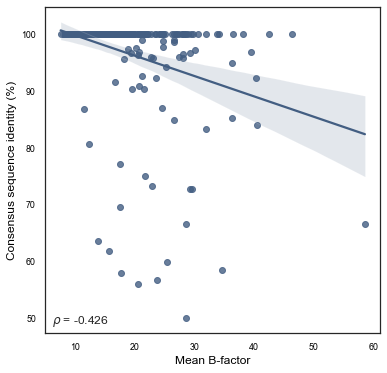

In [114]:
colors = sb.cubehelix_palette(5, start=.5, rot=-.7, light=.97)

fig, ax = plt.subplots(figsize=(6, 6))

plot_df = pd.read_csv("data/tablesALL_rota.JOY_annot.site-merge.tab", sep="\t")
plot_df.dropna(inplace=True)
coeff, pval = stats.spearmanr(plot_df["mean_b_factor"],
                              plot_df["consensus_seq_id%"])

sb.regplot(x="mean_b_factor",
           y="consensus_seq_id%", color=colors[3],
           ax=ax, data=plot_df)

ax.text(.02, .03, r'$\rho$ = %.3f' %
        (coeff), fontsize=12, transform=ax.transAxes)
ax.set_xlabel("Mean B-factor", fontsize=12)
ax.set_ylabel("Consensus sequence identity (%)", fontsize=12)
fig.savefig("figures/rotastate_variability.meanBfactor_v_rotaseqid%.regplot.pdf", format='pdf',
            bbox_inches='tight', dpi=fig.dpi)

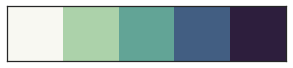

In [117]:
sb.palplot(colors)

mean 96.66589059525114
mean_exp: 96.03888387283614; mean_bur 98.34827178362984
spearmanr: -0.4256127507384285 ; pval: 6.8622651991e-12


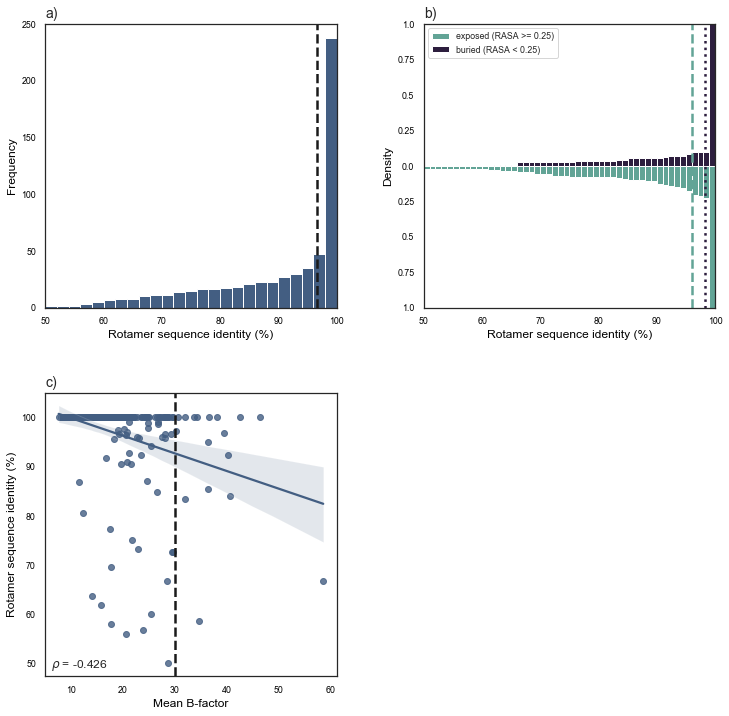

In [186]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
ax1, ax2, ax3, ax4 = axes.flatten()

plot_df = pd.read_csv("data/tablesALL_rota.JOY_annot.site-merge.tab", sep="\t")
plot_df.dropna(inplace=True)
id_mean = plot_df['consensus_seq_id%'].mean()
print(f"mean {id_mean}")

colors = sb.cubehelix_palette(5, start=.5,
                              rot=-.7,
                              light=.97)

binwidth = 2
bin_arr = np.arange(50, 100 + binwidth, binwidth)
plot_df['consensus_seq_id%'].hist(bins=bin_arr,
                                  color=colors[3],
                                  cumulative=True, ax=ax1)
ax1.axvline(id_mean, linestyle="--", linewidth=2.5, color="k")
# Hide grid lines
ax1.grid(False)
ax1.set_xlabel("Rotamer sequence identity (%)", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)
ax1.set_xlim(50, 100)
ax2.set_ylim(ymax*-1, ymax)
ax1.set_title("a)", loc="left", fontsize=14)
ax1.set_xlim(plot_df2.min()[0], plot_df2.max()[0])
ymax = 50 * round(max(ax1.get_ylim())/50)
ax1.set_ylim(0, ymax)

#############################################################################
# separate residues by exposure
annot_rota_df = pd.read_csv(
    "data/tablesALL_rota.JOY_annot.tab", sep="\t", index_col=None)
exposed_subset = annot_rota_df[annot_rota_df['solvent accessibility'] == "T"]
buried_subset = annot_rota_df[annot_rota_df['solvent accessibility'] == "F"]

arr = []
for subset, name in zip([exposed_subset, buried_subset], ["exposed", "buried"]):
    for site, group in subset[subset["rota_4"] != "-"].groupby("res_num"):
        n = len(group.rota_4.tolist())
        # the consensus rotastate at this site
        R = group.rota_4.value_counts().index[0]
        # percet of sequences that agree w/t consensus at this site
        consensus_seq_id = len(group.rota_4[group.rota_4 == R]) / n * 100.
        arr.append([consensus_seq_id, name])
plot_df2 = pd.DataFrame(arr, columns=["consensus_seq_id", "name"])

# plot symmetric cumulative density histograms
binwidth = 1
bin_arr = np.arange(plot_df2.min()[0], plot_df2.max()[0] + binwidth, binwidth)
plot_df2[plot_df2["name"] == "exposed"].hist(
    bins=bin_arr,
    cumulative=True,
    label="exposed",
    density=True,
    color=colors[2],
    ax=ax2)

plot_df2[plot_df2["name"] == "buried"].hist(
    bins=bin_arr,
    cumulative=True,
    color=colors[4],
    label="buried",
    density=True,
    ax=ax2)

# add means
mean_exp = plot_df2[plot_df2["name"] == "exposed"]["consensus_seq_id"].mean()
ax2.axvline(mean_exp, linestyle="--", linewidth=2.5, color=colors[2])
mean_bur = plot_df2[plot_df2["name"] == "buried"]["consensus_seq_id"].mean()
ax2.axvline(mean_bur, linestyle=":", linewidth=2.5, color=colors[4])
print(f"mean_exp: {mean_exp}; mean_bur {mean_bur}")

# invert II histogram
rectangles_exp = list(ax2.containers[0])  # access each hist bar
heights_exp = [r.get_height() for r in rectangles_exp]
for r, h in zip(rectangles_exp, heights_exp):
    r.set_height(h*-1)
ax2.set_ylim(-1, 1)  # these are density histograms

# Hide grid lines
ax2.grid(False)
ax2.set_xlabel("Rotamer sequence identity (%)", fontsize=12)
ax2.set_ylabel("Density", fontsize=12)
# reset ticklabels for II hist
abs_labels = [np.abs(n) for n in ax2.get_yticks()]
ax2.set_yticklabels(abs_labels)
ax2.set_title("")
ax2.set_title("b)", loc="left", fontsize=14)
ax2.set_xlim(plot_df2.min()[0], plot_df2.max()[0])
h, l = ax2.get_legend_handles_labels()
l = ["exposed (RASA >= 0.25)",
     "buried (RASA < 0.25)"]
ax2.legend(h, l)

#############################################################################

coeff, pval = stats.spearmanr(plot_df["mean_b_factor"],
                              plot_df["consensus_seq_id%"])
print(f"spearmanr: {coeff} ; pval: {pval:1.10e}")
sb.regplot(x="mean_b_factor",
           y="consensus_seq_id%", color=colors[3],
           ax=ax3, data=plot_df)
ax3.axvline(30, linestyle="--", linewidth=2.5, color="k")
ax3.text(.02, .03, r'$\rho$ = %.3f' %
         (coeff), fontsize=12, transform=ax3.transAxes)


ax3.set_xlabel("Mean B-factor", fontsize=12)
ax3.set_ylabel("Rotamer sequence identity (%)", fontsize=12)
ax3.set_title("c)", loc="left", fontsize=14)

ax4.set_visible(False)

fig.savefig("figures/structure_rotaseq_consensus_seq_id_bfactor_cumhist.pdf", format='pdf',
            bbox_inches='tight', dpi=fig.dpi)

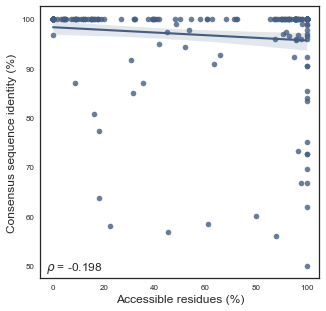

In [16]:
coeff, pval = stats.spearmanr(plot_df["acc_ratio"],
                              plot_df["consensus_seq_id%"])

fig, ax = plt.subplots(1, figsize=(5, 5))
colors = sb.cubehelix_palette(5, start=.5,
                              rot=-.7,
                              light=.97)
sb.regplot(x="acc_ratio",
           y="consensus_seq_id%", color=colors[3],
           ax=ax, data=plot_df)

ax.text(.02, .03, r'$\rho$ = %.3f' %
        (coeff), fontsize=12, transform=ax.transAxes)
ax.set_xlabel("Accessible residues (%)", fontsize=12)
ax.set_ylabel("Consensus sequence identity (%)", fontsize=12)
# fig.savefig("figures/rotastate_variability.meanRMSD_v_variability.regplot.pdf", format='pdf',
#          bbox_inches='tight', dpi=fig.dpi)
plt.show()

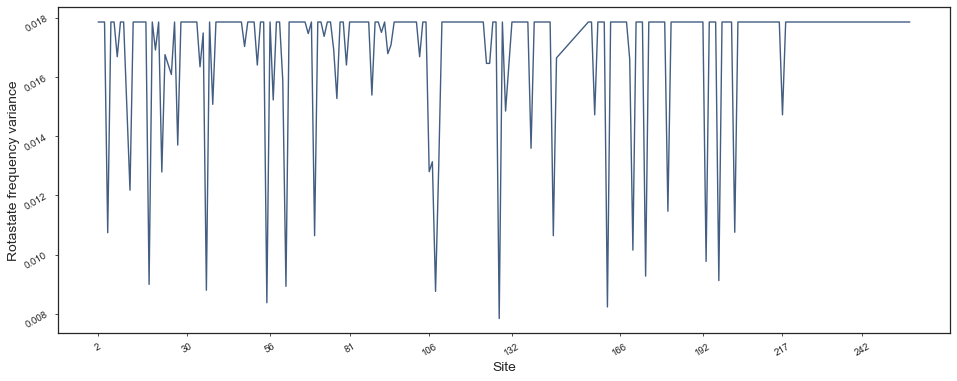

In [6]:
colors = sb.cubehelix_palette(5, start=.5, rot=-.7, light=.97)
fig, ax = plt.subplots(1, figsize=(16, 6))
sb.lineplot(x="residue_number", y="variance",
            color=colors[3], ax=ax, data=plot_df)

ax.tick_params("both", labelsize="small", labelrotation=30, length=3)
ax.set_ylabel("Rotastate frequency variance", fontsize="large")
ax.set_xlabel("Site", fontsize="large")
L = plot_df["residue_number"].unique()
L = L[::25]
ax.set_xticks(L)
ax.set_xticklabels(L)

plt.show()
fig.savefig("figures/rotastate_variability_rotafreq_variance.lineplot.pdf", format='pdf',
            bbox_inches='tight', dpi=fig.dpi)

### Site features correlations

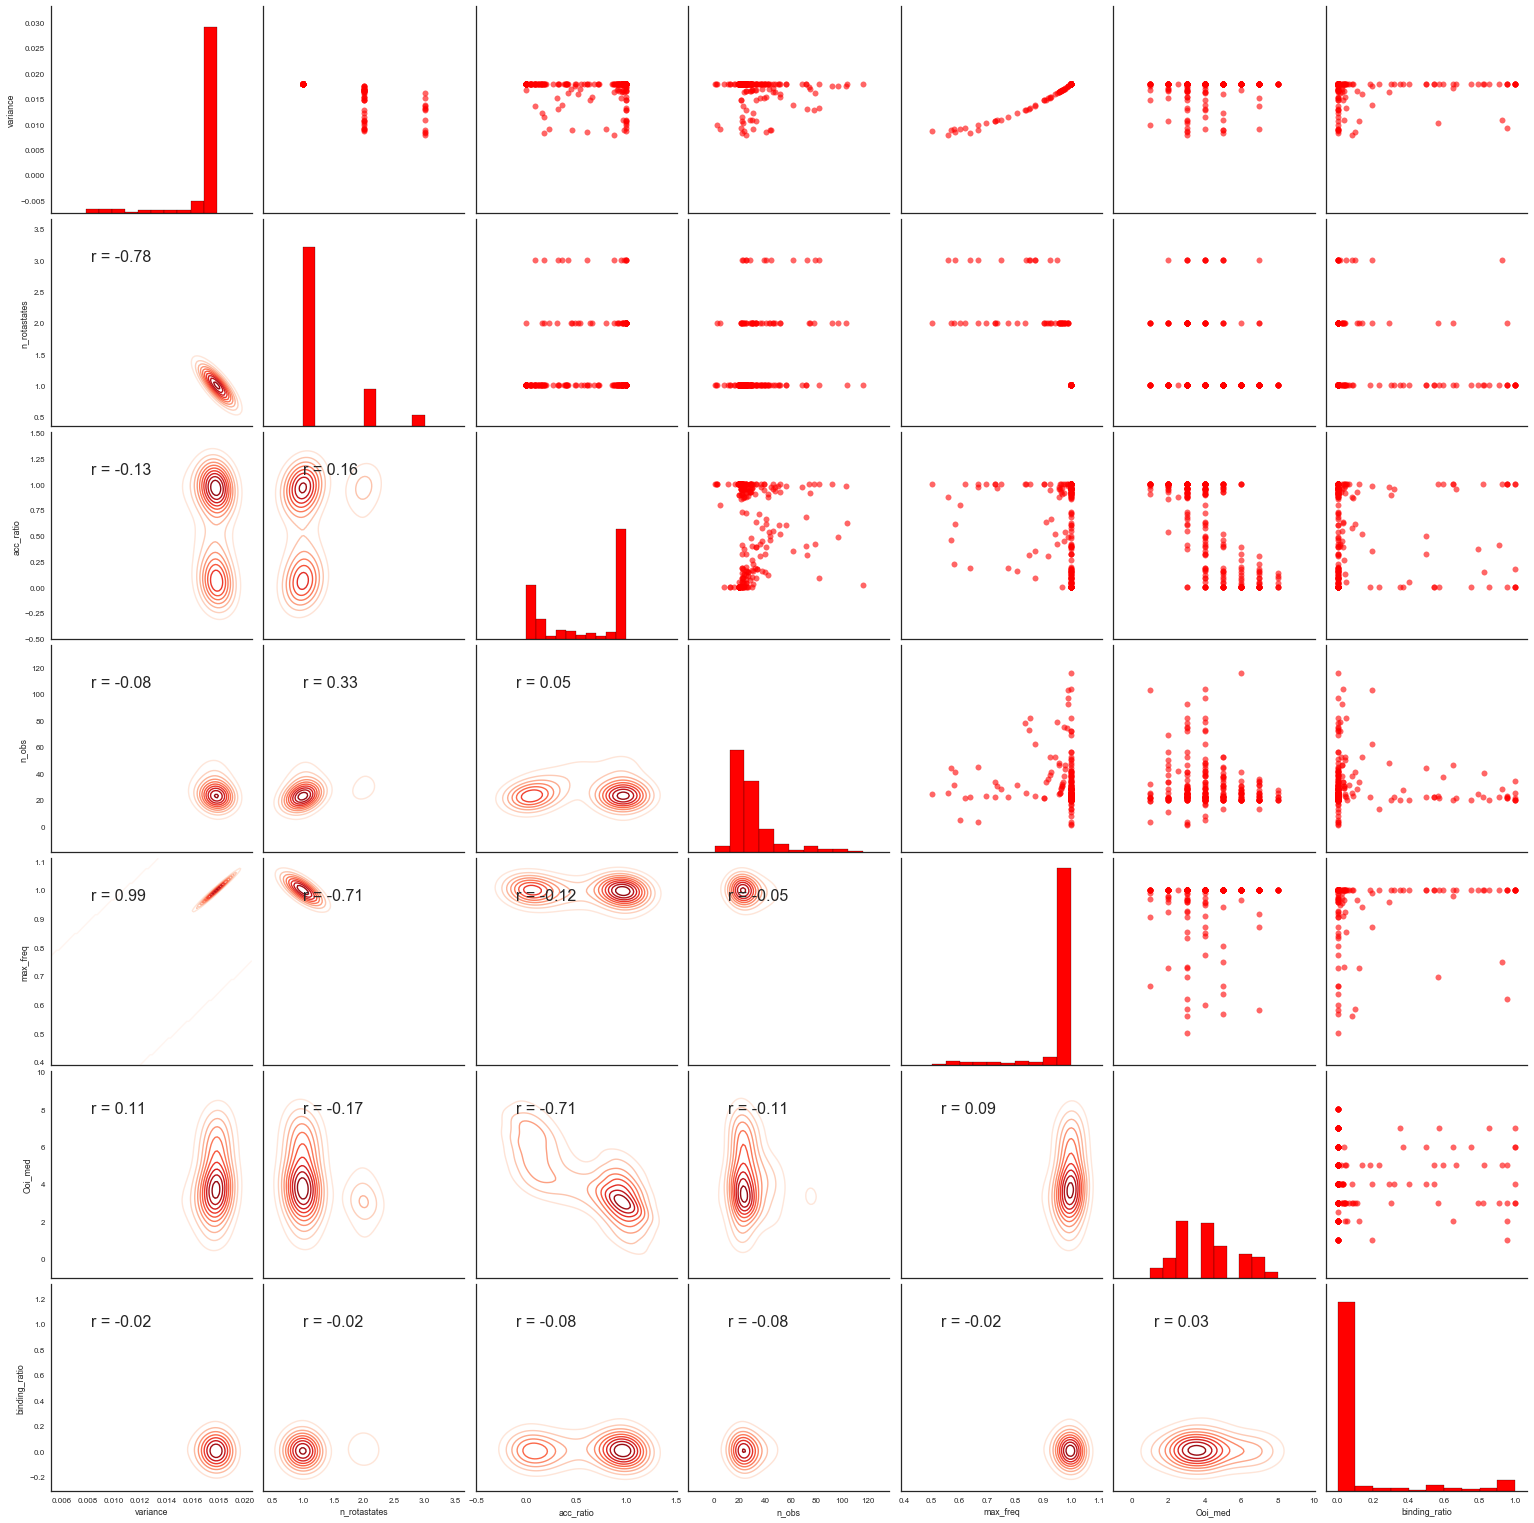

In [7]:
sb.set(font_scale=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", serif='Helvetica Neue')

# site property distribution (KDE) plots
features = pd.read_csv("data/tablesALL_rota.JOY_annot.site-merge.tab", sep="\t")
# Extract the columns to  plot
plot_data = features[['variance', 'n_rotastates', 'acc_ratio', 'n_obs',
                      'max_freq', "Ooi_med", "binding_ratio"]]

# Replace the inf with nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Drop na values
plot_data = plot_data.dropna()

# Function to calculate correlation coefficient between two columns


def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size=16)


# Create the pairgrid object
grid = sb.PairGrid(data=plot_data, size=3)

# Upper is a scatter plot
grid.map_upper(plt.scatter, color='red', alpha=0.6)

# Diagonal is a histogram
grid.map_diag(plt.hist, color='red', edgecolor='black')

# Bottom is correlation and density plot
grid.map_lower(corr_func)
grid.map_lower(sb.kdeplot, cmap=plt.cm.Reds)
grid.savefig("figures/rotastate_variability_site-features.pairplot.pdf", format='pdf',
             bbox_inches='tight', dpi=fig.dpi)

### Rotastate variability and solvent accessibility

There's a weak correlation between chi_1 configuration variability and solvent accessibility as described by Ooi number or JOY (Spearman's R = 0.39 for both). Sites that are accessible appear to be more variable.

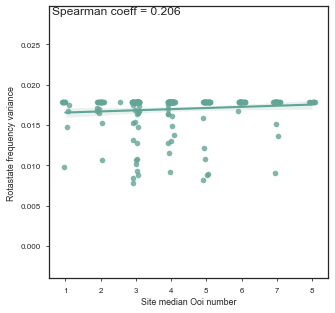

In [2]:
from scipy import stats
plot_df = pd.read_csv("data/tablesALL_rota.JOY_annot.site-merge.tab", sep="\t")
coeff, pval = stats.spearmanr(plot_df["Ooi_med"], plot_df["variance"])

colors = sb.cubehelix_palette(5, start=.5, rot=-.7, light=.97)
fig, ax = plt.subplots(1, figsize=(5, 5))
sb.regplot(x="Ooi_med", y="variance", color=colors[2], x_jitter=.1,
           ax=ax, data=plot_df)

ax.text(.01, .97, 'Spearman coeff = %.3f' %
        (coeff), fontsize=12, transform=ax.transAxes)

ax.tick_params("both", length=3)

# An Ooi number is a count of the number of other Calpha atoms
# within a radius of, in this case, 14Å of the given residue's own Calpha.
# Although crude, this does give a good impression of which parts of the structure
# are buried and which are exposed on the surface.
ax.set_xlabel("Site median Ooi number")
ax.set_ylabel("Rotastate frequency variance")
plt.show()
fig.savefig("figures/rotastate_variability_Ooi_med_v_variance.regplot.pdf", format='pdf',
            bbox_inches='tight', dpi=fig.dpi)

In [3]:
plot_df.head()

Unnamed: 0  residue_number AA  variance  \
0           0               2  V    0.0179   
1           1               3  E    0.0179   
2           2               4  G    0.0179   
3           3               5  S    0.0107   
4           4               6  D    0.0179   

                                          rota_freqs  n_rotastates  acc_ratio  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             1     0.9310   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             1     1.0000   
2  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             1     0.4828   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             2     0.9667   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             1     1.0000   

   Ooi_med  n_obs consensus_rota  binding_ratio  max_freq  
0   5.0000     29           VAL2         0.0000    1.0000  
1   4.0000     29           GLU3         0.0000    1.0000  
2   4.0000     29            GLY         0.0000    1.0000  
3   3.0000     30           SER1         0.0333    0.7333  
4   3.0000     29           ASP3         0.0000    1.0000

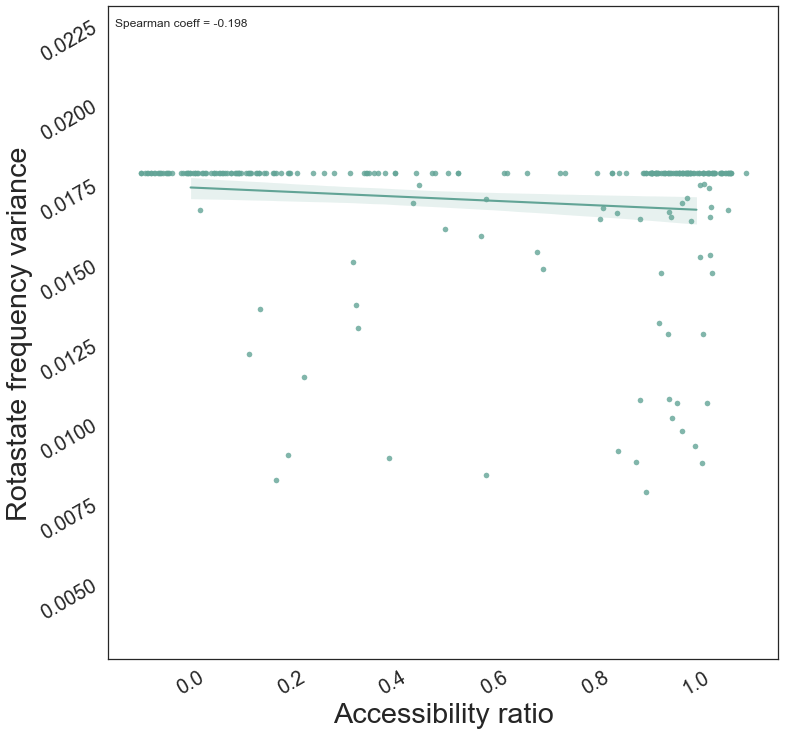

In [9]:
from scipy import stats

plot_df = pd.read_csv("data/tablesALL_rota.JOY_annot.site-merge.tab", sep="\t")
coeff, pval = stats.spearmanr(plot_df["acc_ratio"], plot_df["variance"])

colors = sb.cubehelix_palette(5, start=.5, rot=-.7, light=.97)
fig, ax = plt.subplots(1, figsize=(12, 12))
sb.regplot(x="acc_ratio", y="variance", color=colors[2], x_jitter=.1,
           ax=ax, data=plot_df)

ax.text(.01, .97, 'Spearman coeff = %.3f' %
        (coeff), fontsize=12, transform=ax.transAxes)

ax.tick_params("both", labelsize="small", labelrotation=30, length=3)

ax.set_xlabel("Accessibility ratio", fontsize="large")
ax.set_ylabel("Rotastate frequency variance", fontsize="large")
fig.savefig("figures/rotastate_variability_acc-ratio_v_variance.regplot.pdf", format='pdf',
            bbox_inches='tight', dpi=fig.dpi)
plt.show()

### Rotastate variability and biding sites

No corelation.

In [10]:
plot_df["binding_ratio"].describe()

count   241.0000
mean      0.1069
std       0.2597
min       0.0000
25%       0.0000
50%       0.0000
75%       0.0217
max       1.0000
Name: binding_ratio, dtype: float64

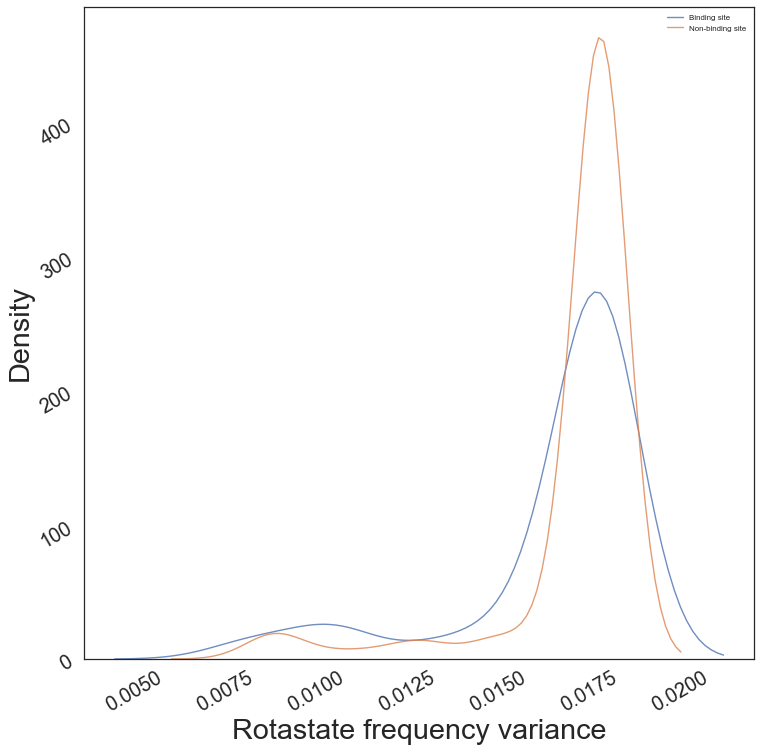

In [11]:
plot_df = pd.read_csv("data/tablesALL_rota.JOY_annot.site-merge.tab", sep="\t")
# plot distribution of variability by ligand type
fig, ax = plt.subplots(1, figsize=(12, 12))

subset = plot_df[plot_df["binding_ratio"] != 0]
sb.kdeplot(subset["variance"], shade=False, label="Binding site", alpha=0.8)
subset = plot_df[plot_df["binding_ratio"] == 0]
sb.kdeplot(subset["variance"], shade=False,
           label="Non-binding site", alpha=0.8)

ax.tick_params("both", labelsize="small", labelrotation=30, length=3)
ax.set_xlabel("Rotastate frequency variance", fontsize="large")
ax.set_ylabel("Density", fontsize="large")
fig.savefig("figures/rotastate_variability_variance_by_binding.kdeplot.pdf", format='pdf',
            bbox_inches='tight', dpi=fig.dpi)

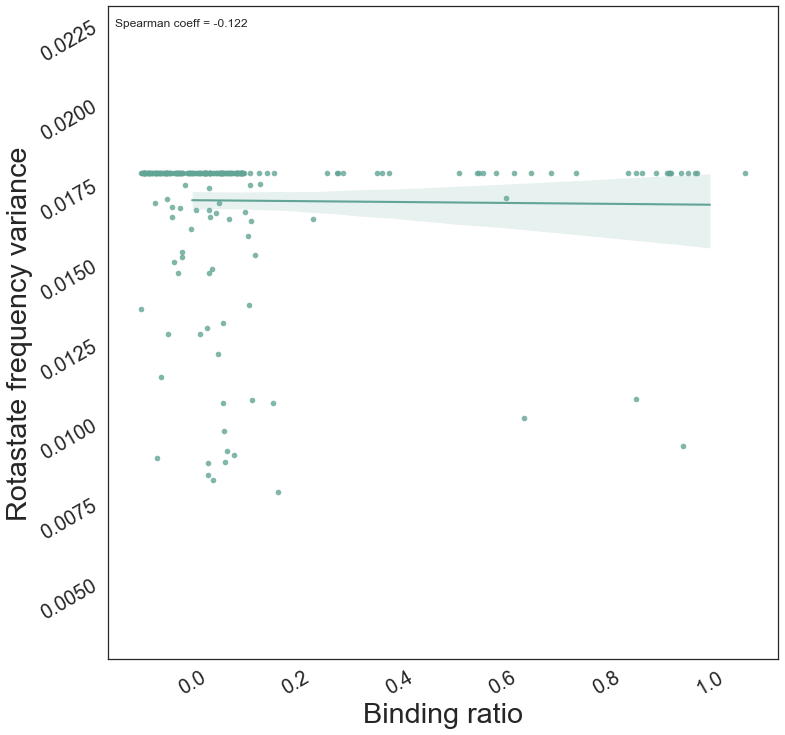

In [12]:
from scipy import stats

plot_df = pd.read_csv("data/tablesALL_rota.JOY_annot.site-merge.tab", sep="\t")
coeff, pval = stats.spearmanr(plot_df["binding_ratio"], plot_df["variance"])

colors = sb.cubehelix_palette(5, start=.5, rot=-.7, light=.97)
fig, ax = plt.subplots(1, figsize=(12, 12))
sb.regplot(x="binding_ratio", y="variance", color=colors[2], x_jitter=.1,
           ax=ax, data=plot_df)

ax.text(.01, .97, 'Spearman coeff = %.3f' %
        (coeff), fontsize=12, transform=ax.transAxes)

ax.tick_params("both", labelsize="small", labelrotation=30, length=3)

ax.set_xlabel("Binding ratio", fontsize="large")
ax.set_ylabel("Rotastate frequency variance", fontsize="large")
fig.savefig("figures/rotastate_variability_binding-ratio_v_variance.regplot.pdf", format='pdf',
            bbox_inches='tight', dpi=fig.dpi)
plt.show()